In [1]:
import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic

from GaHaCo.src.visualization import halo_mass_function as hmf

In [2]:
DATA_PATH = '/cosma5/data/dp004/hvrn44/HOD/'
HALO_MASS_CUT = 1.e11 #solar masses

## Matching halos in the DMO and HYDRO simulations

In [3]:
matching_df = pd.read_csv(DATA_PATH + 'MatchedHaloes_L205n2500.dat',
                         delimiter = ' ', skiprows = 1,
        names = ['ID_DMO', 'ID_HYDRO', 'M200_DMO', 'M200_HYDRO'])

In [4]:
matching_df

,ID_DMO,ID_HYDRO,M200_DMO,M200_HYDRO
0,0,0,1.021000e+15,1.040000e+15
1,1,1,8.764000e+14,8.856000e+14
2,2,2,6.446000e+14,7.000000e+14
3,3,3,5.923000e+14,6.094000e+14
4,4,4,5.618000e+14,5.702000e+14
...,...,...,...,...
507535,233452,17621455,1.074000e+11,1.121000e+09
507536,64861,17622524,4.568000e+11,4.780000e+08
507537,106353,17622884,2.592000e+11,7.641000e+08
507538,39555,17623990,6.809000e+11,6.064000e+08


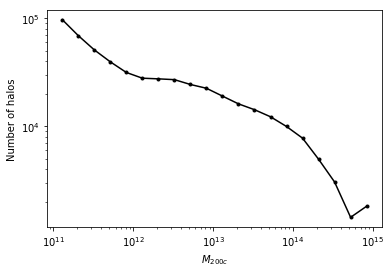

In [5]:
hmf.plot_halo_mass_function(matching_df['M200_DMO'])


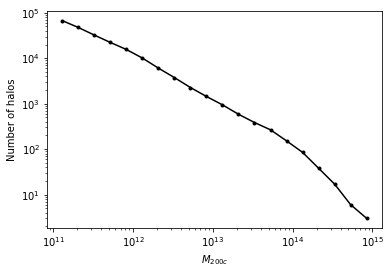

In [6]:
hmf.plot_halo_mass_function(matching_df['M200_HYDRO'])

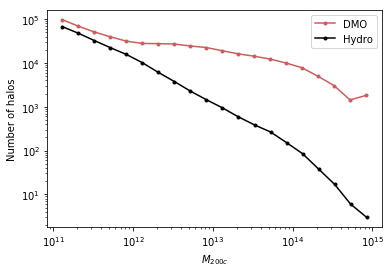

In [8]:
hmf.plot_halo_mass_function(matching_df['M200_DMO'], color = 'indianred', label = 'DMO')
hmf.plot_halo_mass_function(matching_df['M200_HYDRO'], color = 'black', label = 'Hydro')
plt.legend()

In [9]:
print(f'There are {len(np.unique(matching_df.ID_DMO))} unique haloes in the Dark matter only simulation')
print(f'There are {len(np.unique(matching_df.ID_HYDRO))} haloes in the hydro simulation')

There are 228051 unique haloes in the Dark matter only simulation
There are 507540 haloes in the hydro simulation


## Halo mass cut on the DMO ones

In [10]:
mass_matching_df = matching_df.loc[matching_df['M200_DMO'] > HALO_MASS_CUT]

In [11]:
print(f'There are {len(np.unique(mass_matching_df.ID_DMO))} unique haloes above {HALO_MASS_CUT:.1E}'
      ' solar masses in the Dark matter only simulation')

There are 227968 unique haloes above 1.0E+11 solar masses in the Dark matter only simulation


In [12]:
print(f'There are {len(np.unique(mass_matching_df.ID_HYDRO))} unique haloes above {HALO_MASS_CUT:.1E}'
      ' solar masses in the Hydro simulation')

There are 507434 unique haloes above 1.0E+11 solar masses in the Hydro simulation


In [13]:
# keep only unique matchings

idx, count = np.unique(mass_matching_df.ID_DMO, return_counts=True)

Text(0.5,0,'Number of hydro haloes matched to the same DMO halo')

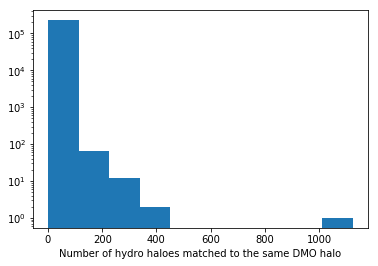

In [14]:
plt.hist(count, log = True)
plt.xlabel('Number of hydro haloes matched to the same DMO halo')

In [15]:
unique_dmo_idx = idx[count == 1]
unique_matching_df = mass_matching_df.loc[mass_matching_df.ID_DMO.isin(unique_dmo_idx)]

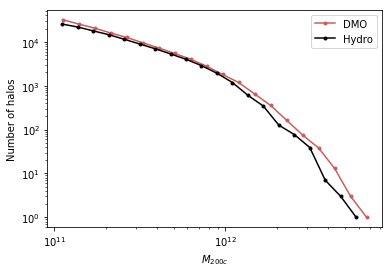

In [16]:
hmf.plot_halo_mass_function(unique_matching_df['M200_DMO'], color = 'indianred', label = 'DMO')
hmf.plot_halo_mass_function(unique_matching_df['M200_HYDRO'], color = 'black', label = 'Hydro')
plt.legend()

## Adding some halo properties from DMO sims

In [17]:
with h5py.File(DATA_PATH + 'HaloProfiles_DMO_z0.00_ext.hdf5', 'r') as hf:
        
       
    mass = hf['Haloes']['M200'][:]
    vmax = hf['Haloes']['Vmax'][:]
    rmax = hf['Haloes']['Rmax'][:]
    r200c = hf['Haloes']['R200'][:]
    cnfw = hf['Haloes']['Cnfw'][:]
    rhosnfw = hf['Haloes']['Rhosnfw'][:]

    massprofile = hf['Haloes']['DMMassProfile'][:]

    parametrized_cnfw = vmax/(rmax * 70)

    properties_ids = hf['Haloes']['GroupNumber'][:]

In [18]:
properties = np.vstack([properties_ids,mass, vmax, rmax,
                                     r200c, cnfw, rhosnfw]).T

In [19]:
properties_df = pd.DataFrame(data = properties,
                             columns = ['ID_DMO', 'M200c', 'Vmax', 'Rmax', 
                                        'R200c', 'Cnfw', 'Rhosnfw'])

In [20]:
properties_df

,ID_DMO,M200c,Vmax,Rmax,R200c,Cnfw,Rhosnfw
0,0.0,1.021094e+15,1720.320608,1.017927,1637.737427,5.698943e+00,3.148591e+06
1,1.0,8.763998e+14,1626.658679,1.095801,1556.385864,4.528827e+00,1.890909e+06
2,2.0,6.445536e+14,1435.573084,0.915569,1404.871216,5.604312e+00,2.870591e+06
3,3.0,5.922584e+14,1418.062988,0.788401,1365.790283,4.750148e+00,2.012141e+06
4,4.0,5.617762e+14,1398.909960,0.767208,1341.978027,5.069929e+00,2.391334e+06
...,...,...,...,...,...,...,...
229260,278079.0,1.007831e+11,103.223734,0.014772,75.686066,5.608999e+01,1.312776e+09
229261,278541.0,1.001213e+11,109.084942,0.011484,75.523170,7.382515e+01,2.832885e+09
229262,279423.0,1.003104e+11,108.027972,0.012738,75.567726,5.663748e+01,1.331717e+09
229263,279745.0,1.006413e+11,117.696697,0.012200,75.648079,3.588773e+07,2.795470e+26


In [21]:
merged_matching_df = pd.merge(unique_matching_df, properties_df, on = ['ID_DMO'], how = 'inner')


## Adding properties from the merger tree info

In [22]:
 
with h5py.File(DATA_PATH + 'MergerTree_L205n2500TNG_DM_ext_New.hdf5',
               'r') as hf:

    
    formation_time = hf['Haloes']['z0p50'][:]
    n_mergers = hf['Haloes']['NMerg'][:]
    mass_peak = hf['Haloes']['Mpeak'][:]
    main_prog_mass = hf['Haloes']['MainProgMass'][:]
    vpeak = hf['Haloes']['Vpeak'][:]
    
    mergertree_ids = hf['Haloes']['Index'][:]


In [23]:
mergertree_data = np.vstack([mergertree_ids, formation_time, n_mergers,
                            mass_peak, vpeak]).T

In [24]:
mergertree_df = pd.DataFrame(data = mergertree_data, 
                columns = ['ID_DMO', 'Formation Time', 'Nmergers','MassPeak', 'vpeak'])

In [25]:
merged_tree_df = pd.merge(merged_matching_df,
                          mergertree_df, on = ['ID_DMO'], how = 'inner')


## Add more features from TNG

In [26]:
tng_path = '/cosma6/data/dp004/dc-cues1/tng_dataframes/'

dmo_file =  'dmo_halos.hdf5'

dmo_df = pd.read_hdf(tng_path + dmo_file)


In [27]:
dmo_merged_df = pd.merge(merged_tree_df, dmo_df, on = ['ID_DMO'], how = 'inner')


In [28]:
dmo_merged_df = dmo_merged_df.drop(columns = ['Group_M_Crit200'])
dmo_merged_df = dmo_merged_df.drop(columns = ['Group_R_Crit200'])


In [29]:
hydro_file = 'hydro_galaxies.hdf5'

hydro_df = pd.read_hdf(tng_path + hydro_file)

hydro_merged_df = pd.merge(dmo_merged_df, hydro_df, on = ['ID_HYDRO'], how = 'inner', suffixes = ('_dmo', '_hydro'))
hydro_merged_df = hydro_merged_df.drop(columns = ['Group_M_Crit200', 'M200_DMO'])


In [30]:
hydro_merged_df

,ID_DMO,ID_HYDRO,M200_HYDRO,M200c,Vmax_x,Rmax,R200c,Cnfw,Rhosnfw,Formation Time,...,fsub_unbound,x_offset,x_dmo,y_dmo,z_dmo,N_gals,M_stars,x_hydro,y_hydro,z_hydro
0,5176,4911,6.413000e+12,7.403636e+12,341.285688,0.193742,316.973663,5.780107,3.311509e+06,0.888712,...,0.104134,466.967921,163.034953,83.229992,179.338828,6.0,1.689195e+11,163.042391,83.221234,179.359734
1,5334,4981,4.846000e+12,5.937365e+12,294.382288,0.298076,294.488647,4.394269,1.596827e+06,0.415892,...,0.196425,563.743651,253.258156,199.109719,227.337500,8.0,1.567598e+11,253.252859,199.115406,227.312312
2,7238,5392,2.440000e+12,2.402108e+12,231.512614,0.352976,217.811813,3.177258,7.646312e+05,0.458952,...,0.698938,529.864573,151.945797,44.601000,157.183750,8.0,1.215231e+11,151.954688,44.607535,157.211750
3,5653,5485,3.960000e+12,4.640279e+12,278.607024,0.190633,271.265900,5.482615,2.777998e+06,0.458491,...,0.350506,190.230539,51.544145,224.332328,70.259312,4.0,1.862292e+11,51.543066,224.303188,70.242992
4,5543,6160,5.426000e+12,6.914848e+12,355.372052,0.085405,309.844360,8.628157,8.548512e+06,0.955517,...,0.024623,515.772693,297.496688,164.154469,148.109125,3.0,1.768937e+11,297.516219,164.154078,148.116297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139679,169414,15666405,3.983000e+08,1.665380e+11,118.816171,0.015918,89.480110,19.172514,6.569397e+07,2.166447,...,0.026969,2489.222894,96.865078,272.791656,212.682844,0.0,0.000000e+00,96.711914,272.890500,212.572469
139680,157986,16588519,1.045000e+09,1.395459e+11,108.840086,0.020274,84.356422,14.366032,3.012063e+07,2.508967,...,0.165185,1552.665188,192.502172,235.569219,185.488594,0.0,0.000000e+00,192.384453,235.359594,185.523047
139681,99063,16847757,1.235000e+09,2.850953e+11,135.821922,0.021882,107.039574,12.763321,2.275998e+07,2.208860,...,0.089717,783.336693,9.396361,6.928338,215.926453,0.0,0.000000e+00,9.590183,7.409898,216.022859
139682,89584,17276508,9.225000e+08,1.173755e+11,92.015236,0.013619,79.628708,7.290335,5.485306e+06,1.277335,...,0.630689,2725.930252,146.579781,15.411195,180.251531,0.0,0.000000e+00,146.562938,15.558385,180.208641


Text(0.5,0,'N galaxies')

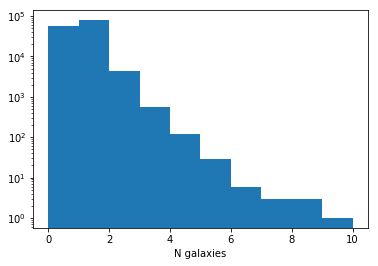

In [31]:
plt.hist(hydro_merged_df.N_gals, log = True)
plt.xlabel('N galaxies')

In [32]:
n_centrals = hydro_merged_df.N_gals > 0
n_satellites = np.where(hydro_merged_df.N_gals > 0, hydro_merged_df.N_gals - 1, 0)

In [33]:
nbins= 20
bins = np.logspace(np.log10(np.min(hydro_merged_df.M200c)),
                   np.log10(np.max(hydro_merged_df.M200c)), nbins+1)

bin_centers = (bins[1:]+bins[:-1])/2.


n_centrals_binned, edges, _ = binned_statistic(hydro_merged_df.M200c,
                                    n_centrals,
                                    statistic = 'mean',
                                    bins=bins)

n_centrals_error, edges, _ = binned_statistic(hydro_merged_df.M200c,
                                    n_centrals, 
                                    statistic = 'std',
                                    bins=bins)

In [34]:
n_satellites_binned, edges, _ = binned_statistic(hydro_merged_df.M200c, 
                                    n_satellites,
                                    statistic = 'mean',
                                    bins=bins)

n_satellites_error, edges, _ = binned_statistic(hydro_merged_df.M200c,
                                    n_satellites, 
                                    statistic = 'std',
                                    bins=bins)

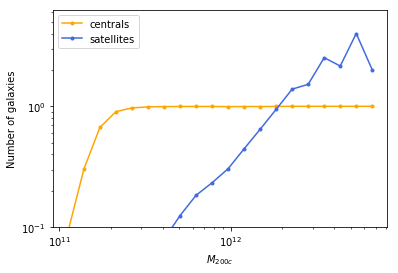

In [35]:
fig = plt.figure()
ax = plt.axes()
ax.plot((edges[1:]+edges[:-1])/2.,
           n_centrals_binned, #yerr = n_centrals_error, 
        color='orange', marker='o',markersize=3,
           label = 'centrals')

ax.plot((edges[1:]+edges[:-1])/2.,
           n_satellites_binned, #yerr = n_satellites_error, 
             color='royalblue', marker='o',markersize=3,
        label = 'satellites')



ax.set_xscale("log")
ax.set_yscale("log")

ax.set_ylabel('Number of galaxies')
ax.set_xlabel(r'$M_{200c}$')
ax.set_ylim(1e-1)
plt.legend()